----

## Data Preprocessing and EDA

In [1]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from scipy.misc import comb
from scipy import ndimage
import pickle
import os
from sklearn.utils import shuffle
from skimage.transform import resize
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Metadata about images

In the provided dataset there were 5 columns. The HH band (band_1), the HV band (band_2), the id of image, the incidence angle, and the label (0-ship, 1-iceberg) <br>

The train.json is the only labeled dataset provided. There was also a test.json provided with all the same data excluding the label. <br>

During the EDA step I looked at how balanced the dataset labels were and the distribution of the incidence angle by class.

In [2]:
df_train = pd.read_json('train.json')
df_train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [26]:
print('Images of ships in training set     ' + str(df_train.is_iceberg[df_train.is_iceberg == 0].count()))
print('Images of icebergs in training set  ' + str(df_train.is_iceberg[df_train.is_iceberg == 1].count()))

Images of ships in training set     851
Images of icebergs in training set  753


Incidence angle did not show a significant difference to the distribution whether the images were of icebergs or ships. In addition, I did not find any way to incorporate this data into the image, so I decided to ignore the incidence angle data for my modeling

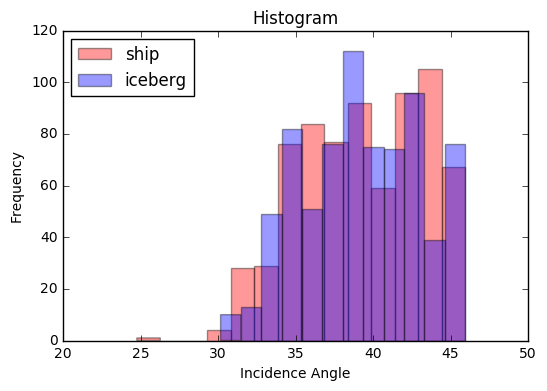

In [4]:
inc_ang_iceberg = df_train.inc_angle[df_train.is_iceberg == 1]
inc_ang_ship = df_train.inc_angle[df_train.is_iceberg != 1]

# Some incidence angle entries are missing, these are removed from the below distributions
inc_ang_iceberg = np.array(inc_ang_iceberg[inc_ang_iceberg != 'na'])
inc_ang_ship = np.array(inc_ang_ship[inc_ang_ship != 'na'])

ax = sns.distplot(inc_ang_ship, kde=False, color='r', label='ship')
ax = sns.distplot(inc_ang_iceberg, kde=False, color='b', label='iceberg')
ax.set(xlabel='Incidence Angle', ylabel='Frequency',title='Histogram')
ax.legend(loc='upper left')

### Prepare image data for CNN, create composite image

Testing input to various CNNs, for input to final best model VGG16 - image of 224x224 pixels requested. However after testing with an input image of 224x224 and 75x75 I found the same result, so used 75x75 pixel as input <br>

Stacked three channels to create composite RGB image, HH (band1), HV (band2), and HH/HV (cross polarization channel). <br>

Wrote full dataset and test / trian split out to a pickle file to be read into VGG16 First Pass notebook

In [5]:
# Function to prepare data for VGG16 model
def prepare_image(X):
    for i, entry in tqdm(enumerate(X)):
        img_75 = np.array(X[i]).reshape(75,75)
        img_75 = img_75 + np.abs(img_75.min())
        img_75 = img_75 / img_75.max() * 255 # Forcing the data to range between 0-255 and using abs to get rid of negatives
        img_75.astype(int)
        img_3d = np.expand_dims(img_75, axis=0) # Include a zero axis, as required by VGG model

        if i == 0:
            X2 = img_3d
        else:
            X2 = np.concatenate((X2,img_3d), axis=0)
            
    return X2

In [6]:
# Create three channels for RGB composite image. HH (band1), HV (band2), HH / HV (cross polarization channel)
X_HH_75 = df_train.band_1
X2_HH_75 = prepare_image(X_HH_75)

X_HV_75 = df_train.band_2
X2_HV_75 = prepare_image(X_HV_75)

X2_B3_75 = (X2_HH_75 + X2_HV_75) / 2

1604it [00:24, 64.89it/s]
1604it [00:24, 65.37it/s]


In [7]:
# Stack separate channels into composite RGB image
HH_HV = np.concatenate((X2_HH_75[..., np.newaxis], X2_HV_75[..., np.newaxis]), axis=3)
HH_HV_Com_75 = np.concatenate((HH_HV,X2_B3_75[..., np.newaxis]), axis=3)
HH_HV_Com_75.shape

(1604, 75, 75, 3)

In [8]:
# Write out pickle file for composite image
with open('HH_HV_Com_75.p', 'wb') as handle:
    pickle.dump(HH_HV_Com_75, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X_train_75, X_test_75, y_train_75, y_test_75 = train_test_split(
    HH_HV_Com_75, y, test_size=0.20, random_state=42)

# Write out test train split data from labeled dataset
pkl_list = [X_train_75, X_test_75, y_train_75, y_test_75]
pkl_list_str = ['X_train_75', 'X_test_75', 'y_train_75', 'y_test_75']

for i, entry in enumerate(pkl_list):
    with open( 'test_train/{0}'.format(pkl_list_str[i])+'.p', 'wb') as handle:
        pickle.dump(entry, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Transform, filter, and view images

In this section I view components of images, HH, HV, cross polarization, and composite image <br>

I ploted panels of ship and icebergs for comparing many examples <br>

Also tested how a gaussian filter affected the channels <br>

In [20]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Function that plots each channel of RGB image, as well as composite image
def plot_image(ind):
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(2,2,1)
    plt.imshow(HH_HV_Com_75[ind, :, :, 0])
    plt.xticks([]), plt.yticks([])
    plt.title('HH Band Image - Iceberg')

    plt.subplot(2,2,2)
    plt.imshow(HH_HV_Com_75[ind, :, :, 1])
    plt.xticks([]), plt.yticks([])
    plt.title('HV Band Image - Iceberg')
    
    plt.subplot(2,2,3)
    plt.imshow(HH_HV_Com_75[ind, :, :, 2])
    plt.xticks([]), plt.yticks([])
    plt.title('Cross Polarization Image - Iceberg')

    plt.subplot(2,2,4)
    plt.xticks([]), plt.yticks([])
    gray = rgb2gray(HH_HV_Com_75[ind])    
    plt.imshow(gray, cmap = plt.get_cmap('coolwarm'))
    plt.title('Composite Image - Iceberg')

# Function that creates image panels of icebergs or ships
def image_panel(iceberg,df_train):
    
    df_train_shuf = shuffle(df_train, random_state=9)
    HH_IP = np.array(df_train_shuf[df_train_shuf.is_iceberg == iceberg].iloc[0,0]).reshape(75, 75)
    HH = df_train_shuf[df_train_shuf.is_iceberg == iceberg].iloc[1:4,0]
    
    for entry in HH:
        HH_IP = np.concatenate((HH_IP, np.array(entry).reshape(75, 75)), axis=1)

    HH_IP2 = np.array(df_train_shuf[df_train_shuf.is_iceberg == iceberg].iloc[5,0]).reshape(75, 75)
    HH = df_train_shuf[df_train_shuf.is_iceberg == iceberg].iloc[6:9, 0]
    
    for entry in HH:
        HH_IP2 = np.concatenate((HH_IP2,np.array(entry).reshape(75, 75)), axis=1)
        
    HH_IP = np.concatenate((HH_IP, HH_IP2), axis=0)
    HV_IP = np.array(df_train_shuf[df_train_shuf.is_iceberg == iceberg].iloc[0, 1]).reshape(75, 75)
    HV = df_train_shuf[df_train_shuf.is_iceberg == iceberg].iloc[1:4, 1]
    
    for entry in HV:
        HV_IP = np.concatenate((HV_IP,np.array(entry).reshape(75, 75)), axis=1)

    HV_IP2 = np.array(df_train_shuf[df_train_shuf.is_iceberg == iceberg].iloc[5, 1]).reshape(75, 75)
    HV = df_train_shuf[df_train_shuf.is_iceberg == iceberg].iloc[6:9, 1]
    
    for entry in HV:
        HV_IP2 = np.concatenate((HV_IP2,np.array(entry).reshape(75, 75)), axis=1)
    
    HV_IP = np.concatenate((HV_IP, HV_IP2), axis=0)
    HH_IP = HH_IP + np.abs(HH_IP.min()) + 1
    HH_IP = HH_IP / HH_IP.max() * 255
    HV_IP = HV_IP + np.abs(HV_IP.min()) + 1
    HV_IP = HV_IP / HV_IP.max() * 255
    HH_HV_IP = HH_IP / HV_IP
    RGB_com_image_panel = np.stack((HH_IP.T,HV_IP.T,HH_HV_IP.T),axis=2)


    image_type = ['Ships','Icebergs']
    plt.figure(figsize=(10, 20))
    plt.xticks([]), plt.yticks([])
    gray = rgb2gray(RGB_com_image_panel)    
    plt.imshow(gray.T, cmap = plt.get_cmap('coolwarm'))
    plt.title('Image Panel of ' + str(image_type[iceberg]))
    plt.savefig('%d_panel'%iceberg)
    plt.show()
    


In [21]:
# Function that shows gaussian filter's affect on HH and HV components
def Plot_filt(ind):
    ex_image_HH = HH_HV_Com_75[ind, :, :, 0]
    ex_image_HV = HH_HV_Com_75[ind, :, :, 1]

    plt.figure(figsize=(10,10))

    plt.subplot(3,2,1)
    plt.imshow(ex_image_HH)
    plt.title('HH Band - no filt')
    plt.xticks([]), plt.yticks([])

    plt.subplot(3,2,2)
    plt.imshow(ex_image_HV)
    plt.title('HV Band - no filt')
    plt.xticks([]), plt.yticks([])
    filt = ['- mild filt','- harsh filt']

    for i in range(1, 3, 1):
        gauss_denoised_HH = ndimage.gaussian_filter(ex_image_HH, i)
        gauss_denoised_HV = ndimage.gaussian_filter(ex_image_HV, i)

        plt.subplot(3,2,2*i+1)
        plt.imshow(gauss_denoised_HH)
        plt.title('HH Band '+ str(filt[i-1]))
        plt.xticks([]), plt.yticks([])

        plt.subplot(3,2,2*i+2)
        plt.imshow(gauss_denoised_HV)
        plt.title('HV Band '+ str(filt[i-1]))
        plt.xticks([]), plt.yticks([])

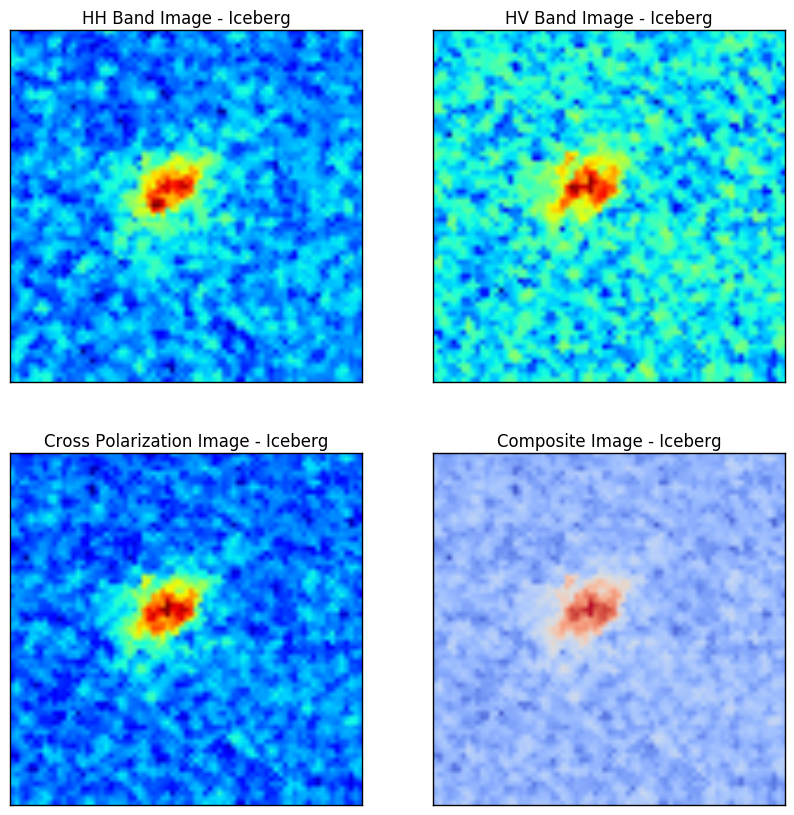

In [22]:
# Plot all three channels and composite image
plot_image(5)

Iceberg images tend to show a more rugose shape, and have a less distinct boundary than ship images. Ship images tend to be elongate. However some images are very difficult to tell apart.

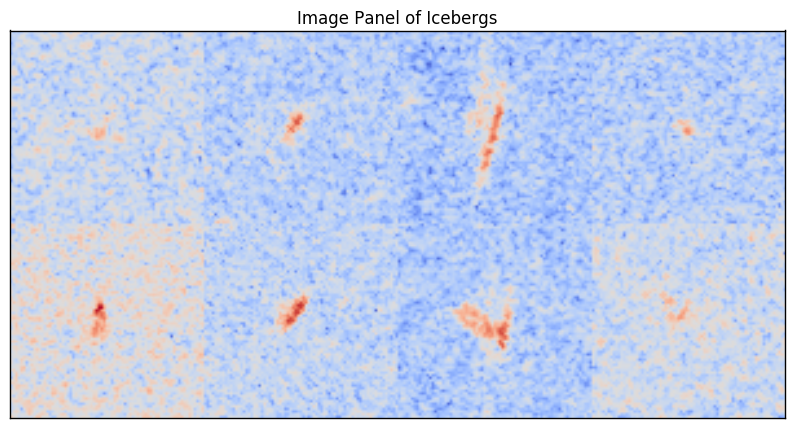

In [23]:
image_panel(1,df_train)

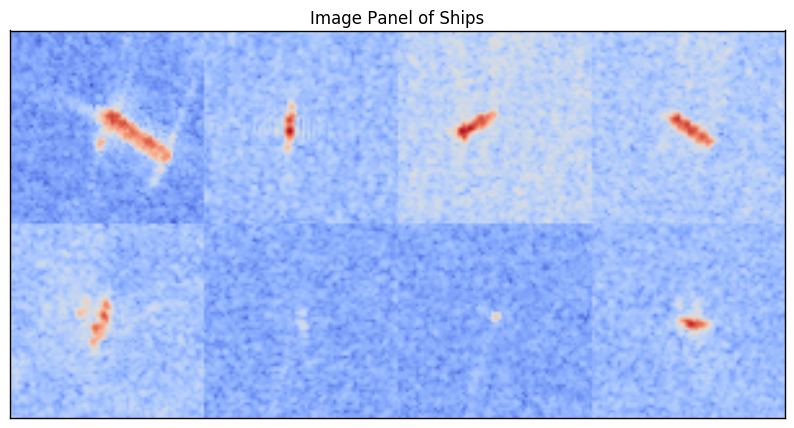

In [24]:
image_panel(0,df_train)

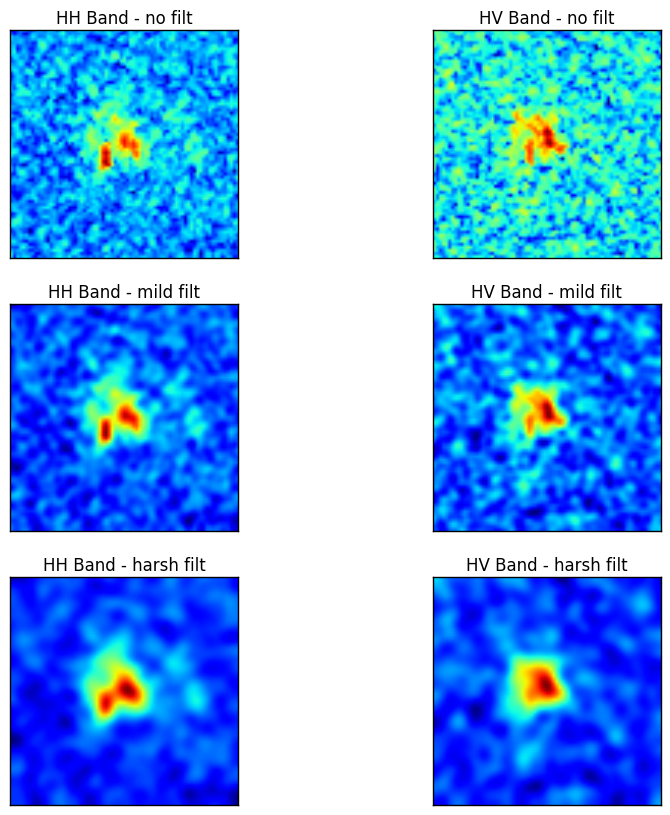

In [25]:
Plot_filt(50)